In [20]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.2


In [196]:
# !pip install labelme opencv-python albumentations


# 1. Setup and Get Data

### 1.2 Collect Images using OpenCV

In [21]:
import os
import time
import uuid
import cv2

In [36]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [37]:
IMAGES_PATH

'data/images'

In [13]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print('Collecting image{}'.format(imgnum))
    ret, frame = cap.read()
    
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):  #usual cv2 break code
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotating Images with LabelMe

In [2]:
!labelme


[INFO   ] __init__:get_config:70 - Loading config file from: /Users/certifiedoreo/.labelmerc
qt.qpa.window: Window position QRect(-113,116 958x459) outside any known screen, using primary screen


# 2 Review Dataset and Build Image loading function  

### 2.1 Import TF and Deps 

In [22]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data pipeline

In [6]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)   #anything with .jpg

Metal device set to: Apple M1


2022-07-01 12:52:51.311560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-01 12:52:51.312449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
images.as_numpy_iterator().next()

b'data/images/9e5a46d2-f90b-11ec-8205-3e9c77ca6aae.jpg'

In [55]:
def load_image(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image) #apply load_image fn to each image path

In [10]:
images.as_numpy_iterator().next()

2022-07-01 12:52:57.689942: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[24, 24, 16],
        [18, 18, 10],
        [13, 13,  5],
        ...,
        [ 6,  6,  4],
        [ 4,  4,  2],
        [ 0,  0,  0]],

       [[18, 18, 10],
        [19, 19, 11],
        [17, 17,  9],
        ...,
        [ 3,  3,  1],
        [ 4,  4,  2],
        [ 0,  0,  0]],

       [[22, 19, 12],
        [24, 21, 14],
        [22, 19, 12],
        ...,
        [ 3,  3,  1],
        [ 4,  4,  2],
        [ 2,  2,  0]],

       ...,

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        ...,
        [21, 16, 10],
        [15, 10,  4],
        [20, 15,  9]],

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [31, 26, 20],
        [18, 14,  5],
        [22, 18,  9]],

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [29, 24, 18],
        [21, 17,  8],
        [17, 13,  4]]], dtype=uint8)

In [11]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib 

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

<function matplotlib.pyplot.show(*args, **kw)>

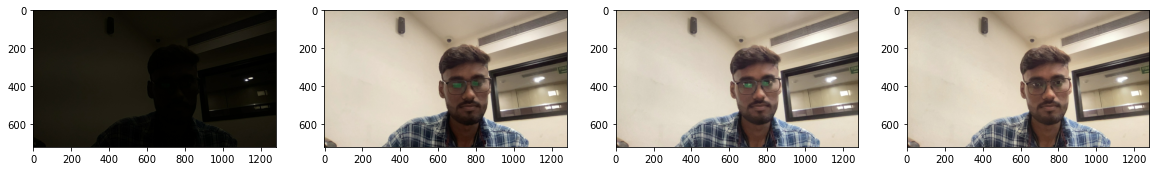

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
    
plt.show

# 3. Partition Unaugmented Data

### 3.1 Manually split data into train test and val

In [15]:
90*.7 #63 images to train

62.99999999999999

In [16]:
90*.15 #14 and 13 images to test and val

13.5

### 3.2 Move the Matching Labels

In [39]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
    
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Applying Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform pipeline

In [31]:
# !pip install --no-deps albumentations
import albumentations as alb

In [32]:
augmentor = alb.Compose([alb.RandomCrop(width=640, height=640), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2  Loading a test image and Annotation with OpenCV and JSON

In [23]:
test_img = cv2.imread(os.path.join('data', 'train', 'images', 'a0ea9f1e-f90b-11ec-8205-3e9c77ca6aae.jpg'))

In [24]:
test_img

array([[[159, 178, 191],
        [163, 182, 195],
        [166, 185, 198],
        ...,
        [ 93,  97, 108],
        [ 88,  93, 102],
        [ 79,  84,  93]],

       [[160, 179, 192],
        [159, 178, 191],
        [164, 183, 196],
        ...,
        [ 68,  72,  83],
        [ 69,  74,  83],
        [ 72,  77,  86]],

       [[161, 180, 193],
        [155, 174, 187],
        [162, 181, 194],
        ...,
        [ 82,  86,  97],
        [ 87,  92, 101],
        [ 90,  95, 104]],

       ...,

       [[ 43,  44,  64],
        [ 42,  44,  62],
        [ 42,  45,  60],
        ...,
        [202, 222, 239],
        [202, 222, 239],
        [201, 221, 238]],

       [[ 42,  44,  62],
        [ 42,  45,  60],
        [ 45,  45,  61],
        ...,
        [202, 222, 239],
        [202, 222, 239],
        [202, 222, 239]],

       [[ 46,  49,  64],
        [ 44,  47,  62],
        [ 44,  44,  60],
        ...,
        [203, 223, 240],
        [203, 223, 240],
        [203, 223, 240]]

In [25]:
#(row (height), column (width), color (3))
#width of image 1280, height of the image 720
test_img.shape  

(720, 1280, 3)

In [26]:
with open(os.path.join('data', 'train', 'labels', 'a0ea9f1e-f90b-11ec-8205-3e9c77ca6aae.json'), 'r') as f:
    label = json.load(f)


In [27]:
label['shapes'][0]['points']

[[766.952380952381, 210.19047619047626],
 [1038.3809523809525, 610.1904761904761]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution 

In [36]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [37]:
coords

[766.952380952381, 210.19047619047626, 1038.3809523809525, 610.1904761904761]

In [38]:
#normalize the coord to convert pascal_voc to albumentations format
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [39]:
coords

[0.5991815476190476,
 0.29193121693121704,
 0.8112351190476191,
 0.8474867724867724]

### 4.4 Apply Augmentations and View Results 

In [47]:
augmented = augmentor(image=test_img, bboxes=[coords], class_labels=['face'])


In [48]:
augmented

{'image': array([[[213, 219, 224],
         [213, 216, 220],
         [214, 213, 215],
         ...,
         [147, 133, 127],
         [140, 128, 122],
         [146, 134, 128]],
 
        [[215, 225, 231],
         [210, 219, 223],
         [211, 216, 219],
         ...,
         [147, 133, 127],
         [139, 127, 121],
         [146, 134, 128]],
 
        [[215, 228, 235],
         [212, 223, 230],
         [209, 219, 226],
         ...,
         [148, 134, 128],
         [144, 132, 128],
         [148, 136, 132]],
 
        ...,
 
        [[107, 110, 124],
         [ 78,  81,  95],
         [ 75,  78,  92],
         ...,
         [117, 141, 161],
         [118, 141, 163],
         [118, 141, 163]],
 
        [[ 78,  81,  95],
         [ 81,  84,  98],
         [ 83,  86, 100],
         ...,
         [118, 142, 162],
         [118, 142, 162],
         [116, 140, 160]],
 
        [[ 89,  92, 106],
         [117, 120, 134],
         [142, 145, 159],
         ...,
         [117, 141,

In [49]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [50]:
augmented['image'] #augmented image

array([[[213, 219, 224],
        [213, 216, 220],
        [214, 213, 215],
        ...,
        [147, 133, 127],
        [140, 128, 122],
        [146, 134, 128]],

       [[215, 225, 231],
        [210, 219, 223],
        [211, 216, 219],
        ...,
        [147, 133, 127],
        [139, 127, 121],
        [146, 134, 128]],

       [[215, 228, 235],
        [212, 223, 230],
        [209, 219, 226],
        ...,
        [148, 134, 128],
        [144, 132, 128],
        [148, 136, 132]],

       ...,

       [[107, 110, 124],
        [ 78,  81,  95],
        [ 75,  78,  92],
        ...,
        [117, 141, 161],
        [118, 141, 163],
        [118, 141, 163]],

       [[ 78,  81,  95],
        [ 81,  84,  98],
        [ 83,  86, 100],
        ...,
        [118, 142, 162],
        [118, 142, 162],
        [116, 140, 160]],

       [[ 89,  92, 106],
        [117, 120, 134],
        [142, 145, 159],
        ...,
        [117, 141, 161],
        [118, 142, 162],
        [117, 141, 161]]

In [68]:
augmented['image']

array([[[148, 170, 188],
        [146, 168, 186],
        [144, 166, 184],
        ...,
        [165, 184, 197],
        [165, 184, 197],
        [163, 182, 195]],

       [[146, 168, 186],
        [145, 167, 185],
        [143, 165, 183],
        ...,
        [169, 188, 201],
        [170, 189, 202],
        [169, 188, 201]],

       [[145, 167, 185],
        [149, 171, 189],
        [143, 165, 183],
        ...,
        [166, 185, 198],
        [169, 188, 201],
        [172, 191, 204]],

       ...,

       [[137, 131, 124],
        [131, 125, 118],
        [128, 122, 115],
        ...,
        [184, 200, 216],
        [184, 200, 216],
        [183, 199, 215]],

       [[138, 135, 127],
        [136, 133, 125],
        [131, 128, 120],
        ...,
        [183, 199, 215],
        [187, 203, 219],
        [185, 201, 217]],

       [[137, 134, 126],
        [141, 138, 130],
        [142, 139, 131],
        ...,
        [179, 195, 211],
        [184, 200, 216],
        [182, 198, 214]]

In [51]:
augmented['bboxes']

[(0.1806547619047617,
  0.14032738095238106,
  0.6047619047619047,
  0.7653273809523808)]

In [52]:
augmented['image']

array([[[213, 219, 224],
        [213, 216, 220],
        [214, 213, 215],
        ...,
        [147, 133, 127],
        [140, 128, 122],
        [146, 134, 128]],

       [[215, 225, 231],
        [210, 219, 223],
        [211, 216, 219],
        ...,
        [147, 133, 127],
        [139, 127, 121],
        [146, 134, 128]],

       [[215, 228, 235],
        [212, 223, 230],
        [209, 219, 226],
        ...,
        [148, 134, 128],
        [144, 132, 128],
        [148, 136, 132]],

       ...,

       [[107, 110, 124],
        [ 78,  81,  95],
        [ 75,  78,  92],
        ...,
        [117, 141, 161],
        [118, 141, 163],
        [118, 141, 163]],

       [[ 78,  81,  95],
        [ 81,  84,  98],
        [ 83,  86, 100],
        ...,
        [118, 142, 162],
        [118, 142, 162],
        [116, 140, 160]],

       [[ 89,  92, 106],
        [117, 120, 134],
        [142, 145, 159],
        ...,
        [117, 141, 161],
        [118, 142, 162],
        [117, 141, 161]]

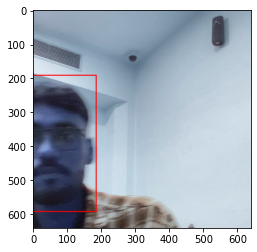

In [53]:
#draw rectangle over the object in augmented image
cv2.rectangle(augmented_test_img['image'],
             tuple(np.multiply(augmented_test_img['bboxes'][0][:2], [640, 640]).astype(int)), #topmost cordinate of boundary box corresponds to x_min, y_min
             tuple(np.multiply(augmented_test_img['bboxes'][0][2:], [640, 640]).astype(int)), #x_max, y_max
                 (255, 0, 0), 2)

plt.imshow(augmented_test_img['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline 

In [72]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try: 
            #creating 60 augmented image for each base image
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: #if no annotations found them means no face in this image 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0       #set classs to 0
                    else: 
                        #face annotation found
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


image must be numpy array type
x_max is less than or equal to x_min for bbox [0.49129464285714286, 0.8144179894179896, 0.3276041666666667, 0.39775132275132297, 'face'].
x_max is less than or equal to x_min for bbox [0.47641369047619053, 0.7416666666666667, 0.260639880952381, 0.2588624338624339, 'face'].
x_max is less than or equal to x_min for bbox [0.43549107142857146, 0.7879629629629632, 0.24203869047619048, 0.3712962962962965, 'face'].
x_max is less than or equal to x_min for bbox [0.5843005952380953, 0.807804232804233, 0.4094494047619047, 0.42420634920634936, 'face'].
x_max is less than or equal to x_min for bbox [0.4094494047619047, 0.7813492063492065, 0.17879464285714286, 0.30515873015873024, 'face'].
x_max is less than or equal to x_min for bbox [0.45409226190476193, 0.7681216931216931, 0.24575892857142856, 0.36468253968253983, 'face'].
x_max is less than or equal to x_min for bbox [0.6475446428571429, 0.8673280423280425, 0.3685267857142857, 0.20595238095238103, 'face'].
x_max i

### 5.2 Load Augmented Images to Tensorflow Dataset 

In [56]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) #compressing the images to make NN work efficiently by providing not much data to it
train_images = train_images.map(lambda x: x/255) #scaling the image


In [57]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [58]:

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [59]:
train_images.as_numpy_iterator().next()

array([[[0.6700436 , 0.6190632 , 0.5837691 ],
        [0.6846405 , 0.63954246, 0.6022876 ],
        [0.68834424, 0.64912856, 0.6099129 ],
        ...,
        [0.68997824, 0.6546841 , 0.5958606 ],
        [0.6947713 , 0.6477124 , 0.59281045],
        [0.6889979 , 0.6419391 , 0.58703715]],

       [[0.6464052 , 0.60718954, 0.56797385],
        [0.6696078 , 0.6215686 , 0.5852941 ],
        [0.6781045 , 0.63888884, 0.59967315],
        ...,
        [0.6908498 , 0.6437909 , 0.58888894],
        [0.6931372 , 0.6460784 , 0.59117645],
        [0.67352915, 0.6264703 , 0.57156837]],

       [[0.64880174, 0.60958606, 0.5703704 ],
        [0.65424836, 0.60326797, 0.56797385],
        [0.66405225, 0.62483656, 0.5856209 ],
        ...,
        [0.69041395, 0.64335513, 0.5884532 ],
        [0.68169934, 0.6346405 , 0.57973856],
        [0.6816995 , 0.62679756, 0.57581717]],

       ...,

       [[0.88485825, 0.8534857 , 0.8025053 ],
        [0.89052266, 0.8591501 , 0.8081697 ],
        [0.8835511 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading function

In [60]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']
    

### 6.2 Load Labels to Tensorflow Dataset 

In [61]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [63]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [64]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3623, 0.606 , 0.578 , 0.9033], dtype=float16))

# 7. Combine Label and Image Samples 

### 7.1 Checking Partition Lengths

In [65]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6900, 6900, 720, 720, 1320, 1320)

### 7.2 Create Final Datasets (Images/Labels) 

In [66]:
#combine images with labels
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000) #this shuffle buffer should be greater than no. of samples (3720 here)
train = train.batch(8)     #batch size
train = train.prefetch(4)  #helps to eliminate bottlenecks while loading and training the data

In [67]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = train.shuffle(1300)
test = train.batch(8)
test = train.prefetch(4)

In [68]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = train.shuffle(1000)
val = train.batch(8)
val = train.prefetch(4)

In [69]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [70]:
train.as_numpy_iterator().next()[1] #labels and bounding boxes of each sample in the batch

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.757  , 0.01064, 1.     , 0.71   ],
        [0.2812 , 0.5825 , 0.497  , 0.88   ],
        [0.3057 , 0.1323 , 0.611  , 0.5713 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.774  , 0.52   , 1.     , 0.877  ],
        [0.2015 , 0.1588 , 0.6704 , 0.791  ],
        [0.     , 0.     , 0.08795, 0.319  ],
        [0.569  , 0.3464 , 1.     , 0.8374 ]], dtype=float16))

### 7.3 View Images and Annotations

In [71]:
data_samples = train.as_numpy_iterator()

In [72]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


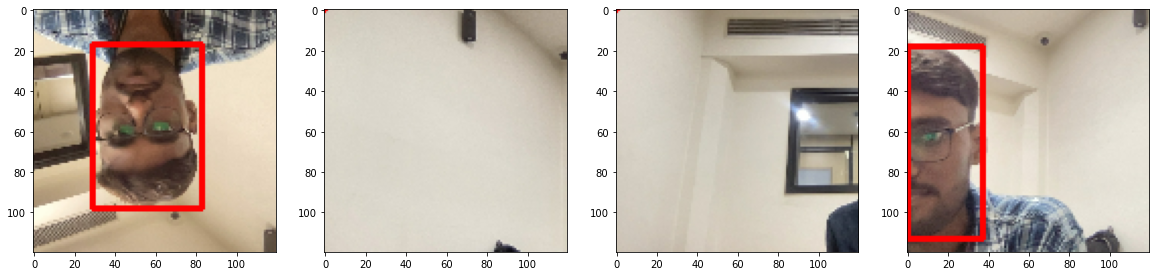

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    #draw the rectangle on face using openCV
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 8. Build Deep Learning Model using the Functional API


In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [105]:
vgg = VGG16(include_top = False)


58889256/58889256 [==============================] - 15s 0us/step


In [107]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [108]:
def build_model():
    #define input layer of 120*120*3 shape
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer) #pass the input to vgg16 NN
    
    #Clasification Model
    f1 = GlobalMaxPooling2D()(vgg)                   #get condensed (max-pooled) vgg output
    class1 = Dense(2048, activation = 'relu')(f1)    #fc of 2048 units
    class2 = Dense(1, activation='sigmoid')(class1)  #face or not face class
    
    #Bounding Box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)       #fc of 2048 units
    regress2 = Dense(4, activation='sigmoid')(regress1) #4-bounding box points
    
    facetracker = Model(inputs = input_layer, outputs=[class2, regress2])  #our facetracker NN model
    return facetracker

In [109]:
facetracker = build_model()

In [110]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [111]:
#grab a sample
X, y = train.as_numpy_iterator().next()   #X=image, y=class,bbox

In [122]:
X.shape

(8, 120, 120, 3)

In [126]:
y[1]

array([[0.6343 , 0.4658 , 1.     , 1.     ],
       [0.304  , 0.223  , 0.7207 , 0.7363 ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.6426 , 0.1674 , 1.     , 0.703  ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.9634 , 0.1976 , 1.     , 0.5845 ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.581  , 0.12445, 0.946  , 0.66   ]], dtype=float16)

In [113]:
classes, coords = facetracker.predict(X) #as of now facetracker is not trained so output will be crap but we are just trying the facetracker model xD

2022-07-01 16:38:11.781094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [114]:
classes, coords

(array([[0.5677978 ],
        [0.48699462],
        [0.5997494 ],
        [0.6295281 ],
        [0.5611668 ],
        [0.57745993],
        [0.56011844],
        [0.58469886]], dtype=float32),
 array([[0.5961089 , 0.48491922, 0.4114383 , 0.590767  ],
        [0.5722112 , 0.44947344, 0.43694353, 0.6992918 ],
        [0.61777264, 0.4312016 , 0.42145744, 0.7041834 ],
        [0.53175694, 0.42343748, 0.30630213, 0.6181924 ],
        [0.62278044, 0.45514995, 0.35359904, 0.70736897],
        [0.6141852 , 0.40385392, 0.38582483, 0.67405   ],
        [0.5993596 , 0.5276869 , 0.3585153 , 0.6837657 ],
        [0.5303835 , 0.52773756, 0.3396362 , 0.7024814 ]], dtype=float32))

## 9. Defining Loss fns and Optimizers

### 9.1 Define Optimizer and LR

In [116]:
len(train)

863

In [117]:
#let us specify how to decrease the learning rate in such a way
#that we are 75% of original learning rate after each epoch and this
#means we'll slow down the learning so ideally we don't overfit and we
#don't blow out our gradients
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [119]:
#Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

### 9.2 Create Localization Loss and Classification Loss 

In [152]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))  #penalizing pred x_min, y_min
    
    h_true = y_true[:,3] - y_true[:, 1]  #h = y_max - y_min
    w_true = y_true[:,2] - y_true[:, 0]  #w = x_max - x_min
    
    
    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred)) #penalizing boundary height & width
    
    return delta_coord + delta_size
    


In [153]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

### 9.3 Testing out Loss Metrics

In [157]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.50342>

In [158]:
class_loss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.674325>

In [159]:
regress_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.50342>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [160]:
#Neural Net class


class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
        

    def compile(self, optimizer, classloss, localizationloss, **kwargs):
    '''
    Whenever we build a keras neural network, we typically create the network
    set self.compile and to our compile.method we pass our loss and optimizer
    
    '''
        super().compile(**kwargs)  #since this is a subclass model
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = optimizer
    
    def train_step(self, batch, **kwargs):
        
        X, y = batch                     #each training step will get one batch of data
        
        with tf.GradientTape() as tape:  #keep records of all calculations by builing the computation graph
            classes, coords = self.model(X, training=True)   #make prediction
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss  #as of now considered 50% of classloss only, we can tweak it later
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) #calculate gradients w.r.t loss fn
        opt.apply_gradients(zip(grad, self.model.trainable_variables))       #applying one-step of gradient descent
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs):   #if we want to use model.predict then we need to define this call fn
        return self.model(X, **kwargs)


In [161]:
model = FaceTracker(facetracker)

In [162]:
model.compile(opt, class_loss, regress_loss)

### 10.2 Train 

In [164]:
logdir = 'logs'

In [165]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [166]:
hist = model.fit(train, epochs = 40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


2022-07-02 20:04:00.678822: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_10'
2022-07-02 20:04:00.731884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


863/863 [==============================] - ETA: 0s - total_loss: 0.5758 - class_loss: 0.2007 - regress_loss: 0.4754

2022-07-02 20:06:54.283615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


863/863 [==============================] - 231s 249ms/step - total_loss: 0.5752 - class_loss: 0.2005 - regress_loss: 0.4749 - val_total_loss: 0.0554 - val_class_loss: 0.0555 - val_regress_loss: 0.0277
Epoch 2/40
863/863 [==============================] - 234s 260ms/step - total_loss: 0.2887 - class_loss: 0.1082 - regress_loss: 0.2347 - val_total_loss: 0.6499 - val_class_loss: 0.4685 - val_regress_loss: 0.4156
Epoch 3/40


2022-07-02 20:11:53.497865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4859 of 5000
2022-07-02 20:11:53.769147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 267s 297ms/step - total_loss: 0.2044 - class_loss: 0.0767 - regress_loss: 0.1660 - val_total_loss: 0.2749 - val_class_loss: 0.1875 - val_regress_loss: 0.1812
Epoch 4/40
863/863 [==============================] - 270s 301ms/step - total_loss: 0.1630 - class_loss: 0.0596 - regress_loss: 0.1332 - val_total_loss: 0.7799 - val_class_loss: 0.2883 - val_regress_loss: 0.6357
Epoch 5/40
863/863 [==============================] - 275s 308ms/step - total_loss: 0.0985 - class_loss: 0.0369 - regress_loss: 0.0801 - val_total_loss: 0.0060 - val_class_loss: 0.0048 - val_regress_loss: 0.0036
Epoch 6/40
863/863 [==============================] - 281s 315ms/step - total_loss: 0.1033 - class_loss: 0.0358 - regress_loss: 0.0854 - val_total_loss: 0.2696 - val_class_loss: 0.1742 - val_regress_loss: 0.1824
Epoch 7/40
863/863 [==============================] - 281s 315ms/step - total_loss: 0.0697 - class_loss: 0.0251 - regress_loss: 0.0572 - val_total_loss: 0.0046 - v

2022-07-02 20:49:16.421060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4973 of 5000
2022-07-02 20:49:16.470244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 312s 350ms/step - total_loss: 0.0429 - class_loss: 0.0124 - regress_loss: 0.0367 - val_total_loss: 0.0094 - val_class_loss: 6.1972e-08 - val_regress_loss: 0.0094
Epoch 12/40
863/863 [==============================] - 289s 323ms/step - total_loss: 0.0235 - class_loss: 0.0066 - regress_loss: 0.0202 - val_total_loss: 0.0012 - val_class_loss: 1.8672e-04 - val_regress_loss: 0.0012
Epoch 13/40
863/863 [==============================] - 315s 354ms/step - total_loss: 0.0189 - class_loss: 0.0054 - regress_loss: 0.0162 - val_total_loss: 0.0072 - val_class_loss: 5.2773e-04 - val_regress_loss: 0.0070
Epoch 14/40


2022-07-02 21:04:32.643781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4431 of 5000
2022-07-02 21:04:33.786091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 328s 367ms/step - total_loss: 0.0161 - class_loss: 0.0037 - regress_loss: 0.0143 - val_total_loss: 0.0063 - val_class_loss: 4.0848e-04 - val_regress_loss: 0.0061
Epoch 15/40
863/863 [==============================] - 275s 307ms/step - total_loss: 0.0224 - class_loss: 0.0082 - regress_loss: 0.0183 - val_total_loss: 0.0095 - val_class_loss: 2.5822e-05 - val_regress_loss: 0.0095
Epoch 16/40
863/863 [==============================] - 265s 297ms/step - total_loss: 0.0207 - class_loss: 0.0059 - regress_loss: 0.0177 - val_total_loss: 0.0011 - val_class_loss: 1.0915e-04 - val_regress_loss: 0.0011
Epoch 17/40
863/863 [==============================] - 267s 299ms/step - total_loss: 0.0099 - class_loss: 0.0018 - regress_loss: 0.0090 - val_total_loss: 0.0081 - val_class_loss: 1.2938e-04 - val_regress_loss: 0.0080
Epoch 18/40
863/863 [==============================] - 269s 302ms/step - total_loss: 0.0110 - class_loss: 0.0028 - regress_loss: 0.0096 - val_to

2022-07-02 22:44:23.089785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4197 of 5000
2022-07-02 22:44:24.935779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 299s 333ms/step - total_loss: 0.0010 - class_loss: 1.5483e-05 - regress_loss: 0.0010 - val_total_loss: 2.4196e-04 - val_class_loss: 1.1981e-06 - val_regress_loss: 2.4136e-04
Epoch 37/40
863/863 [==============================] - 291s 326ms/step - total_loss: 9.5940e-04 - class_loss: 5.8361e-06 - regress_loss: 9.5648e-04 - val_total_loss: 3.7307e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 3.7307e-04
Epoch 38/40


2022-07-02 22:54:13.170106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4565 of 5000
2022-07-02 22:54:14.227633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 319s 357ms/step - total_loss: 8.7638e-04 - class_loss: 5.6371e-06 - regress_loss: 8.7356e-04 - val_total_loss: 4.0967e-04 - val_class_loss: 3.3672e-06 - val_regress_loss: 4.0799e-04
Epoch 39/40


2022-07-02 22:59:32.479365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4722 of 5000
2022-07-02 22:59:33.005272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


863/863 [==============================] - 289s 323ms/step - total_loss: 8.8072e-04 - class_loss: 4.2361e-06 - regress_loss: 8.7860e-04 - val_total_loss: 9.1933e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 9.1933e-04
Epoch 40/40
863/863 [==============================] - 294s 330ms/step - total_loss: 9.2404e-04 - class_loss: 1.1596e-05 - regress_loss: 9.1825e-04 - val_total_loss: 2.6250e-04 - val_class_loss: 0.0000e+00 - val_regress_loss: 2.6250e-04


### 10.3 Plot Performance

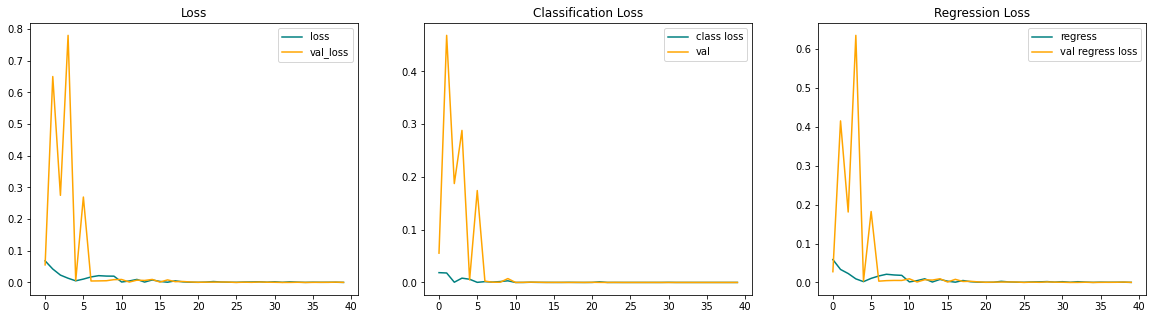

In [169]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()
plt.show()




# 11. Make Predictions

## 11.1 Make Predictions on Test set

In [79]:
test_data = test.as_numpy_iterator()


In [80]:
test_sample = test_data.next()


In [81]:
yhat = facetracker.predict(test_sample[0])


1/1 [==============================] - 0s 299ms/step


2022-07-03 15:51:40.727310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


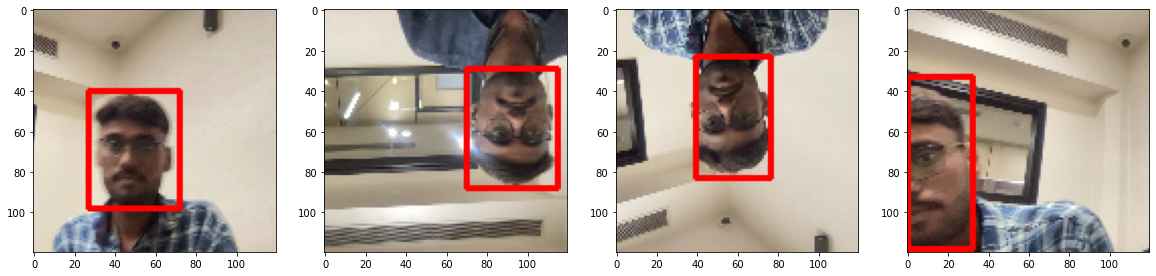

In [82]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


## 11.2 Save the Model 

In [76]:
from tensorflow.keras.models import load_model

In [194]:
facetracker.save('facetracker.h5')

In [195]:
facetracker = load_model('facetracker.h5')


# 11.3 Real Time Detection

In [85]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[60:700, 60:700, :] #cutting down the 640*640 size (augmented size)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #convert  bgr to rgb (openCV reads in bgr)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [640,640]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [640,640]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [640,640]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [640,640]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [640,640]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

    